###YOLO 8.1 구글 코랩에서 실행 필요, 
quit()이 존재하므로 모두 실행시 오류가 남. quit()이후부터는 자동실행 오류 없음

In [ ]:
!git clone --recursive https://github.com/AILab-CVC/YOLO-World
%cd YOLO-World/

In [ ]:
import os
# Install certain version of requests,tqdm,rich for openxlab (fix for yolo_world)
# Install mmcv before avoding compiling of mmcv and shortining waiting time installs "whl" file
if 'COLAB_GPU' in os.environ:
  !pip install requests==2.28.2 tqdm==4.65.0 rich==13.4.2
  %pip install -U openmim
  !mim install "mmengine>=0.7.0"
  !mim install "mmcv"
else:
  !pip install torch wheel requests==2.28.2 tqdm==4.65.0 rich==13.4.2


!pip install -e . -vv

###세션 다운 필요

In [3]:
# Restart collab session (required for mmengine)
quit()

###다시 실행후 다운 받기

In [ ]:
!wget https://huggingface.co/spaces/stevengrove/YOLO-World/resolve/main/yolow-v8_l_clipv2_frozen_t2iv2_bn_o365_goldg_pretrain.pth?download=true
!mv yolow-v8_l_clipv2_frozen_t2iv2_bn_o365_goldg_pretrain.pth?download=true yolow-v8_l_clipv2_frozen_t2iv2_bn_o365_goldg_pretrain.pth
!wget https://huggingface.co/spaces/stevengrove/YOLO-World/resolve/main/configs/pretrain/yolo_world_l_t2i_bn_2e-4_100e_4x8gpus_obj365v1_goldg_train_lvis_minival.py?download=true
!mv yolo_world_l_t2i_bn_2e-4_100e_4x8gpus_obj365v1_goldg_train_lvis_minival.py?download=true yolo_world_l_t2i_bn_2e-4_100e_4x8gpus_obj365v1_goldg_train_lvis_minival.py
!cp -r yolo_world_l_t2i_bn_2e-4_100e_4x8gpus_obj365v1_goldg_train_lvis_minival.py /content/YOLO-World/configs/pretrain/

In [ ]:
import numpy as np
import torch
from mmengine.config import Config
from mmengine.dataset import Compose
from mmengine.runner import Runner
from mmengine.runner.amp import autocast
from mmyolo.registry import RUNNERS
from torchvision.ops import nms


if __name__ == "__main__":
    # load config
    cfg = Config.fromfile(
        "/content/YOLO-World/configs/pretrain/yolo_world_l_t2i_bn_2e-4_100e_4x8gpus_obj365v1_goldg_train_lvis_minival.py"
    )
    cfg.work_dir = "."
    cfg.load_from = "yolow-v8_l_clipv2_frozen_t2iv2_bn_o365_goldg_pretrain.pth"
    runner = Runner.from_cfg(cfg)
    runner.call_hook("before_run")
    runner.load_or_resume()
    pipeline = cfg.test_dataloader.dataset.pipeline
    runner.pipeline = Compose(pipeline)
    runner.model.eval()

###구글 다운로드 폴더만들고 디렉토리 수정

In [16]:
import os

# 폴더 이름을 정의합니다.
folder_name = "input_folder"

# 현재 작업 디렉토리에 새로운 폴더를 생성합니다.
os.makedirs(folder_name, exist_ok=True)

In [17]:
%cd /content/input_folder

/content/input_folder


###구글 드라이브에서 사진 다운로드 후 UNZIP

In [ ]:
!pip install -U --no-cache-dir gdown --pre

In [ ]:
!gdown --id 1YE-UM9owrkjMoO-YIvGIIPVj3qZQ77MB

In [ ]:
!unzip /content/input_folder/idol_sample.zip -d /content/input_folder

#얼굴 인식 후 상반신으로 크롭해주는 함수

In [34]:
import PIL.Image
import supervision as sv
import numpy as np
import torch
from torch.cuda.amp import autocast
import os

# Supervision에서 사용하는 객체 초기화
bounding_box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator(text_position=sv.Position.CENTER)

class_names = ("face") #클래스 

def process_and_save_images(runner, input_folder, output_folder="/content/output_images"):

    # 출력 폴더가 없으면 생성
    os.makedirs(output_folder, exist_ok=True)

    # 입력 폴더 내의 각 이미지에 대해 처리
    for filename in os.listdir(input_folder):
        # 이미지 파일 형식 확인 및 확장자 필터링
        if filename.endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            # 입력 이미지의 경로 설정
            input_image_path = os.path.join(input_folder, filename)
            # 이미지 처리
            img = run_image(runner, input_image_path, output_folder)

            # 처리된 이미지 저장
            output_image_path = os.path.join(output_folder, filename.rsplit('.', 1)[0] + ".png")
            img.save(output_image_path)
            print(f"처리된 이미지 저장됨: {output_image_path}")

# 예측된 인스턴스를 출력하는 함수
def print_pred_instances(pred_instances):
    print("Predicted Instances:")
    for idx, (bbox, label, score) in enumerate(zip(pred_instances['bboxes'], pred_instances['labels'], pred_instances['scores'])):
        print(f"Instance {idx + 1}:")
        print(f"  - Bounding Box: {bbox}")
        print(f"  - Label: {label}")
        print(f"  - Confidence Score: {score}")

    print()

def crop_image_with_bbox(image, bbox, factor= 2):
    xmin, ymin, xmax, ymax = bbox
    width = xmax - xmin
    height = ymax - ymin
    x_center = (xmax + xmin) / 2
    y_center = (ymax + ymin) / 2
    new_width = width * factor
    new_height = height * factor
    new_xmin = max(0, int(x_center - new_width / 2))
    new_ymin = max(0, int(y_center - new_height / 2))
    new_xmax = min(image.width, int(x_center + new_width / 2))
    new_ymax = min(image.height, int(y_center + new_height / 2))
    expanded_bbox = (new_xmin, new_ymin, new_xmax, new_ymax)
    cropped_image = image.crop(expanded_bbox)
    return cropped_image

def run_image(
        runner,
        input_image,
        output_folder="/content/output_images",
        max_num_boxes=300,
        score_thr=0.02,
        nms_thr=0.2,
):
    # 모델 실행을 위한 데이터 준비
    texts = [[t.strip()] for t in class_names.split(",")] + [[" "]]
    data_info = runner.pipeline(dict(img_id=0, img_path=input_image, texts=texts))
    data_batch = dict(inputs=data_info["inputs"].unsqueeze(0), data_samples=[data_info["data_samples"]])
    input_file_name = os.path.splitext(os.path.basename(input_image))[0]

    # 모델 실행
    with autocast(enabled=False), torch.no_grad():
        output = runner.model.test_step(data_batch)[0]
        runner.model.class_names = texts
        pred_instances = output.pred_instances

    # NMS 수행
    keep_idxs = nms(pred_instances.bboxes, pred_instances.scores, iou_threshold=nms_thr)
    pred_instances = pred_instances[keep_idxs]
    pred_instances = pred_instances[pred_instances.scores.float() > score_thr]

    # 최대 박스 수 제한
    if len(pred_instances.scores) > max_num_boxes:
        indices = pred_instances.scores.float().topk(max_num_boxes)[1]
        pred_instances = pred_instances[indices]
    output.pred_instances = pred_instances

    # 예측된 인스턴스를 numpy 배열로 변환
    pred_instances = pred_instances.cpu().numpy()

    # 입력 이미지 열기
    image = PIL.Image.open(input_image).convert("RGB")

    # 예측된 바운딩 박스와 라벨로 객체 생성
    detections = sv.Detections(
        xyxy=pred_instances['bboxes'],
        class_id=pred_instances['labels'],
        confidence=pred_instances['scores']
    )

    labels = [f"{class_id} {confidence:0.2f}" for class_id, confidence in zip(detections.class_id, detections.confidence)]

    svimage = np.array(image)
    cropped_images = []

    # 각 객체에 대해 이미지 잘라내기, 리사이즈 및 패딩 적용 후 저장
    for idx, bbox in enumerate(detections.xyxy):
        cropped_image = crop_image_with_bbox(image, bbox)

        # Annotations 추가
        svimage = bounding_box_annotator.annotate(svimage, detections)
        svimage = label_annotator.annotate(svimage, detections)

        output_filename = f"cropped_image_{input_file_name}_{idx}.png"
        output_image_path = os.path.join(output_folder, output_filename)
        os.makedirs(os.path.dirname(output_image_path), exist_ok=True)
        cropped_image.save(output_image_path)
        cropped_images.append(output_image_path)

    print(f"크기가 조정되고 저장된 이미지: {cropped_images}")

    # 예측된 인스턴스 출력
    print_pred_instances(pred_instances) # instance print 조정가능

    return svimage[:, :, ::-1]

###input_folder에 있는 사진의 얼굴을 감지하여 상반신을 크롭

크기가 조정되고 저장된 이미지: ['/content/output_images/cropped_image_333_0.png']
Predicted Instances:
Instance 1:
  - Bounding Box: [203.89586  54.98782 331.39795 218.40077]
  - Label: 0
  - Confidence Score: 0.06822554767131805

Filename: 333.jpg


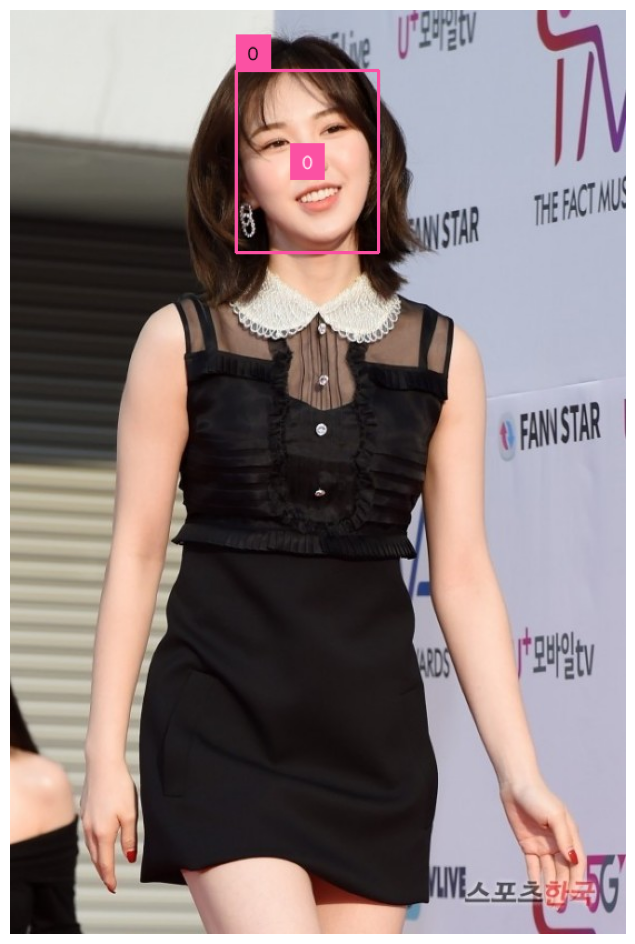

크기가 조정되고 저장된 이미지: ['/content/output_images/cropped_image_472_0.png']
Predicted Instances:
Instance 1:
  - Bounding Box: [182.69185 120.7711  338.35016 310.7016 ]
  - Label: 0
  - Confidence Score: 0.20829889178276062

Filename: 472.jpg


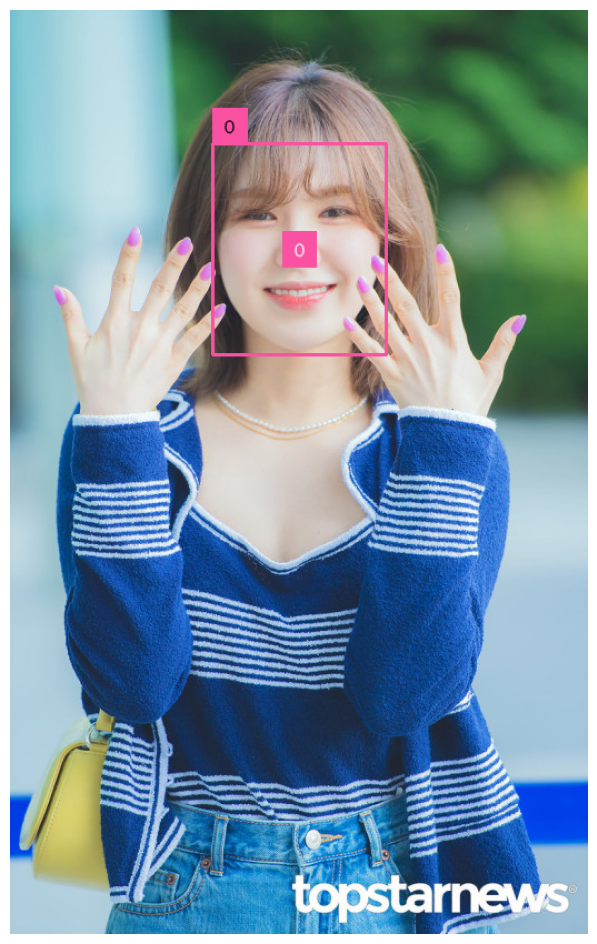

크기가 조정되고 저장된 이미지: ['/content/output_images/cropped_image_194_0.png']
Predicted Instances:
Instance 1:
  - Bounding Box: [215.586   106.38426 367.98532 302.19034]
  - Label: 0
  - Confidence Score: 0.2456306517124176

Filename: 194.jpg


KeyboardInterrupt: 

In [36]:
import os

# Process each image in the input folder and plot the image
input_folder = "/content/input_folder/idol_sample/레드벨벳 웬디"

# Process each image in the input folder
for filename in os.listdir(input_folder):
    if filename.endswith(('.jpg', '.jpeg', '.png', '.bmp')):  # 이미지 파일 형식에 따라 확장자 추가
        input_image_path = os.path.join(input_folder, filename)

        try:
            # Process image
            img = run_image(runner, input_image_path)

            # Plot image
            print(f"Filename: {filename}")
            sv.plot_image(img)

        except Exception as e:
            print(f"Error processing {filename}: {str(e)}")
            continue  # 에러가 발생하면 다음 이미지로 넘어감

폴더zip으로 만들기

In [ ]:
import shutil
shutil.make_archive('/content/download', 'zip', '/content/output_images')

'/content/download.zip'

###크롭된 모든 이미지 확인하기

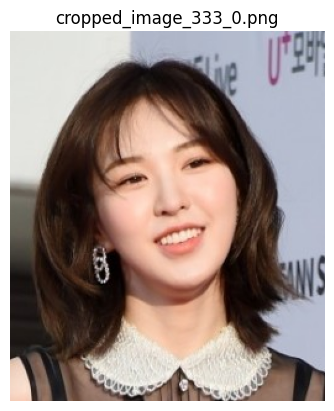

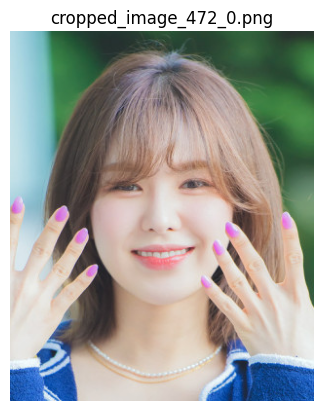

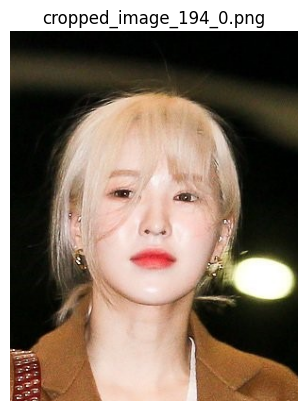

In [37]:
import matplotlib.pyplot as plt
import os
import cv2

# 이미지가 있는 디렉토리
image_dir = '/content/output_images'

# output_images 디렉토리에 있는 모든 이미지 파일 이름 가져오기
image_files = os.listdir(image_dir)

# 이미지 파일들을 하나씩 처리하여 표시
for image_file in image_files:
    # 이미지 파일의 전체 경로
    image_path = os.path.join(image_dir, image_file)

    # 이미지 파일 읽기
    image = cv2.imread(image_path)

    # 이미지가 존재하는 경우에만 표시
    if image is not None:
        # 이미지 표시
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(image_file)  # 이미지 파일 이름을 제목으로 설정
        plt.axis('off')  # 축 제거
        plt.show()

###배경을 다 지워주는 함수

In [38]:
import cv2
import torch
from PIL import Image
from torchvision import transforms
from matplotlib import pyplot as plt

def load_model():
  model = torch.hub.load('pytorch/vision:v0.6.0', 'deeplabv3_resnet101', pretrained=True)
  model.eval()
  return model

def make_transparent_foreground(pic, mask):
  # split the image into channels
  b, g, r = cv2.split(np.array(pic).astype('uint8'))
  # add an alpha channel with and fill all with transparent pixels (max 255)
  a = np.ones(mask.shape, dtype='uint8') * 255
  # merge the alpha channel back
  alpha_im = cv2.merge([b, g, r, a], 4)
  # create a transparent background
  bg = np.zeros(alpha_im.shape)
  # setup the new mask
  new_mask = np.stack([mask, mask, mask, mask], axis=2)
  # copy only the foreground color pixels from the original image where mask is set
  foreground = np.where(new_mask, alpha_im, bg).astype(np.uint8)

  return foreground

def remove_background(model, input_file):
  input_image = Image.open(input_file)
  preprocess = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])

  input_tensor = preprocess(input_image)
  input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

  # move the input and model to GPU for speed if available
  if torch.cuda.is_available():
      input_batch = input_batch.to('cuda')
      model.to('cuda')

  with torch.no_grad():
      output = model(input_batch)['out'][0]
  output_predictions = output.argmax(0)

  # create a binary (black and white) mask of the profile foreground
  mask = output_predictions.byte().cpu().numpy()
  background = np.zeros(mask.shape)
  bin_mask = np.where(mask, 255, background).astype(np.uint8)

  foreground = make_transparent_foreground(input_image ,bin_mask)

  return foreground, bin_mask

###배경 지운 후 저장 및 확인

Downloading: "https://github.com/pytorch/vision/zipball/v0.6.0" to /root/.cache/torch/hub/v0.6.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:04<00:00, 58.4MB/s]


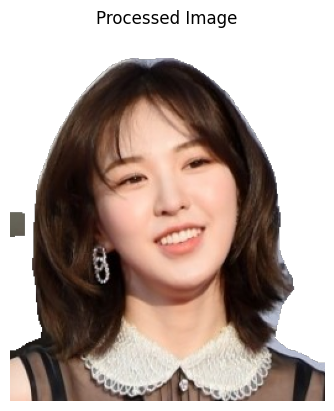

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


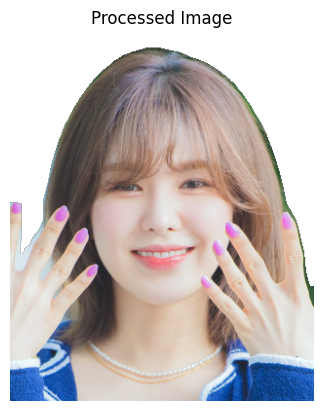

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


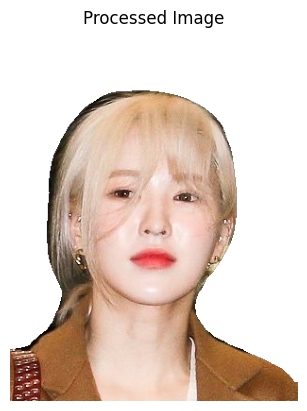

이미지 저장 완료: /content/processed_images


In [39]:
import os
import numpy as np
import shutil
import matplotlib.pyplot as plt

# 결과를 저장할 폴더 경로 설정
output_folder = '/content/processed_images'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# 1. /content/output_images에 있는 모든 사진 파일 가져오기
image_dir = '/content/output_images'
image_files = os.listdir(image_dir)

for image_file in image_files:
    # 파일 확장자가 이미지 파일인지 확인 (예를 들어, .jpg, .png 등)
    if image_file.endswith('.jpg') or image_file.endswith('.png'):
        # 2. 각 사진에 대해 주어진 코드 적용
        deeplab_model = load_model()
        image_path = os.path.join(image_dir, image_file)
        foreground, bin_mask = remove_background(deeplab_model, image_path)

        # 결과 이미지를 저장할 파일 경로 설정
        result_filename = image_file.replace('.jpg', '_processed.jpg').replace('.png', '_processed.png')
        result_filepath = os.path.join(output_folder, result_filename)
        plt.imsave(result_filepath, foreground)  # 이미지를 저장

        # 결과 이미지 표시
        plt.imshow(foreground)
        plt.title('Processed Image')
        plt.axis('off')
        plt.show()

print("이미지 저장 완료:", output_folder)

###zip으로 다운로드

In [ ]:
import shutil
shutil.make_archive('/content/no_back', 'zip', '/content/processed_images')